In [ ]:

import re
import numpy as np
import pandas as pd
from collections import defaultdict

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, confusion_matrix

import matplotlib.pyplot as plt

# Paths
AUDIT_LOG_PATH = "../../Dataset/modsec/modsec_audit_20.log"
LABELS_PATH = "../../Dataset/modsec/modsec_labels_20.csv"

RANDOM_STATE = 42
TEST_SIZE = 0.2
C_PARAM = 0.5

In [ ]:

rule_pattern = re.compile(r'\[id\s*"(\d+)"\]', re.IGNORECASE)
tx_pattern = re.compile(r"--([a-zA-Z0-9]+)-[A-Z]--")

transactions = defaultdict(set)
current_tx = None

with open(AUDIT_LOG_PATH, "r", encoding="utf-8", errors="ignore") as f:
    for line in f:
        tx_match = tx_pattern.search(line)
        if tx_match:
            current_tx = tx_match.group(1)
            if current_tx not in transactions:
               transactions[current_tx] = set()

        rule_match = rule_pattern.search(line)
        if rule_match and current_tx:
            rule_id = rule_match.group(1)
            transactions[current_tx].add(rule_id)

print(f"Transacciones procesadas: {len(transactions)}")


Transacciones procesadas: 15


In [ ]:
all_rules = sorted({r for rules in transactions.values() for r in rules})
rule_to_index = {rule: idx for idx, rule in enumerate(all_rules)}

print(f"Número de reglas CRS detectadas: {len(rule_to_index)}")


Número de reglas CRS detectadas: 2


In [ ]:
tx_ids = list(transactions.keys())

X = np.zeros((len(tx_ids), len(rule_to_index)), dtype=int)

for i, tx in enumerate(tx_ids):
    for rule in transactions[tx]:
        X[i, rule_to_index[rule]] = 1

print("Shape de X:", X.shape)


Shape de X: (15, 2)


In [ ]:
labels_df = pd.read_csv(LABELS_PATH)
label_map = dict(zip(labels_df.transaction_id, labels_df.label))
y = np.array([label_map[tx] for tx in tx_ids])
print(y)
print("Shape de y:", y.shape)


[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1]
Shape de y: (15,)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=y
)

print("Train:", X_train.shape, "Test:", X_test.shape)


Train: (12, 2) Test: (3, 2)


## Experimentos Reproducidos

En esta sección se reproducen los experimentos reportados en el artículo original de
ModSec-Learn. Cada experimento se describe brevemente, seguido de su ejecución y la
obtención de resultados cuantitativos.



### Experimento 1: Baseline ModSecurity

**Objetivo:**  
Establecer una línea base utilizando el mecanismo estándar de ModSecurity, basado en
puntuaciones heurísticas, para evaluar su tasa de detección y tasa de falsos positivos.

**Procedimiento:**  
Se evalúan las solicitudes del conjunto de prueba utilizando únicamente el mecanismo de
puntuación heurística del CRS, sin aplicar ningún modelo de aprendizaje automático.

**Métricas:**  
- Tasa de Verdaderos Positivos (TPR)  
- Tasa de Falsos Positivos (FPR)


In [ ]:
# Baseline heurístico: scores precomputados por ModSecurity
#baseline_scores = np.load(os.path.join(DATA_PATH, "baseline_scores.npy"))
#
## Umbral original de ModSecurity
#THRESHOLD = 5
#
#y_pred_baseline = (baseline_scores >= THRESHOLD).astype(int)
#
#cm = confusion_matrix(y_test, y_pred_baseline)
#tn, fp, fn, tp = cm.ravel()
#
#tpr_baseline = tp / (tp + fn)
#fpr_baseline = fp / (fp + tn)
#
#tpr_baseline, fpr_baseline
#

### Experimento 2: ModSec-Learn con Regresión Logística

**Objetivo:**  
Verificar si un modelo de Regresión Logística entrenado con activaciones de reglas CRS
mejora el trade-off entre TPR y FPR respecto al baseline.

**Procedimiento:**  
Se entrena un modelo de Regresión Logística utilizando vectores binarios de activación de
reglas CRS y el conjunto de entrenamiento balanceado. El modelo se evalúa sobre el
conjunto de prueba.

**Parámetros clave:**  
- Regularización: ℓ₁ y ℓ₂  
- Parámetro C = 5 × 10⁻¹

**Métricas:**  
- Curva ROC  
- TPR a FPR bajos (≈ 1 %)


In [ ]:
lr_l1 = LogisticRegression(
    penalty="l1",
    solver="liblinear",
    C=C_PARAM,
    max_iter=1000
)

lr_l1.fit(X_train, y_train)

y_scores_lr = lr_l1.decision_function(X_test)
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_scores_lr)
auc_lr = auc(fpr_lr, tpr_lr)



print("AUC LR:", auc_lr)



AUC LR: 0.5


### Experimento 3: ModSec-Learn con SVM Lineal

**Objetivo:**  
Evaluar el rendimiento de un modelo SVM lineal como alternativa al modelo de Regresión
Logística para la combinación de reglas CRS.

**Procedimiento:**  
Se entrena un modelo SVM lineal utilizando el mismo conjunto de características y los
mismos datos de entrenamiento empleados en el experimento anterior.

**Parámetros clave:**  
- Regularización ℓ₁ / ℓ₂  
- Parámetro C = 5 × 10⁻¹

**Métricas:**  
- Curva ROC  
- Comparación directa con Regresión Logística


In [ ]:
svm_l1 = LinearSVC(
    penalty="l1",
    dual=False,
    C=C_PARAM,
    max_iter=5000
)

svm_l1.fit(X_train, y_train)

y_scores_svm = svm_l1.decision_function(X_test)
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_scores_svm)
auc_svm = auc(fpr_svm, tpr_svm)


print("AUC SVM:", auc_svm)

AUC SVM: 1.0


### Experimento 4: ModSec-Learn con Random Forest

**Objetivo:**  
Analizar el comportamiento de un modelo no lineal en la combinación de reglas CRS y
compararlo con los modelos lineales.

**Procedimiento:**  
Se entrena un modelo Random Forest utilizando los mismos vectores de características y se
evalúa su rendimiento sobre el conjunto de prueba.

**Métricas:**  
- Curva ROC  
- Comparación con modelos lineales


In [ ]:
rf = RandomForestClassifier(
    n_estimators=100,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

rf.fit(X_train, y_train)

y_scores_rf = rf.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_scores_rf)
auc_rf = auc(fpr_rf, tpr_rf)


print("AUC RF:", auc_rf)

AUC RF: 1.0


In [ ]:
def tpr_at_fpr(fpr, tpr, target=0.01):
    idx = np.where(fpr <= target)[0]
    return tpr[idx[-1]] if len(idx) > 0 else 0.0

print("TPR@1% FPR")
print("LR :", tpr_at_fpr(fpr_lr, tpr_lr))
print("SVM:", tpr_at_fpr(fpr_svm, tpr_svm))
print("RF :", tpr_at_fpr(fpr_rf, tpr_rf))



TPR@1% FPR
LR : 0.0
SVM: 1.0
RF : 1.0


### Experimento 5: Análisis de Dispersión de Reglas

**Objetivo:**  
Verificar si la regularización dispersa permite eliminar un subconjunto significativo de
reglas CRS sin degradar el rendimiento del sistema.

**Procedimiento:**  
Se analiza el vector de pesos aprendido por los modelos lineales con regularización ℓ₁,
identificando reglas con peso cero.

**Métricas:**  
- Número de reglas seleccionadas  
- Porcentaje de reducción de reglas  
- Impacto en TPR y FPR


In [ ]:
coefficients = lr_l1.coef_[0]

num_rules = len(coefficients)
num_zero = np.sum(coefficients == 0)

reduction_pct = num_zero / num_rules * 100

print("Reglas totales:", num_rules)
print("Reglas eliminadas:", num_zero)
print(f"Reducción: {reduction_pct:.2f}%")


Reglas totales: 2
Reglas eliminadas: 2
Reducción: 100.00%


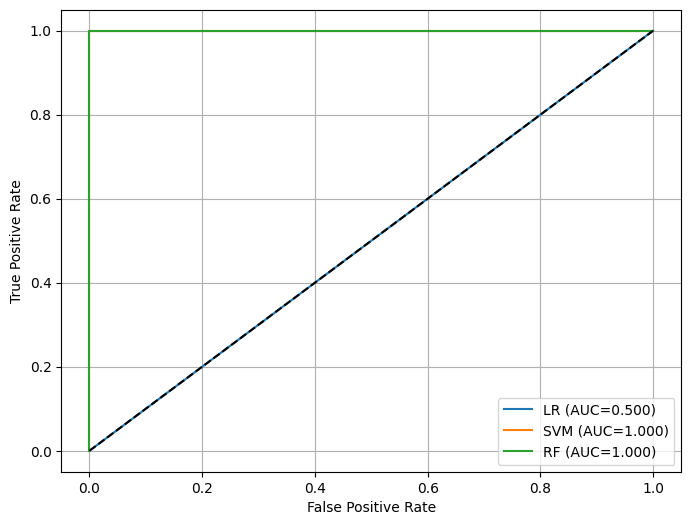

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(fpr_lr, tpr_lr, label=f"LR (AUC={auc_lr:.3f})")
plt.plot(fpr_svm, tpr_svm, label=f"SVM (AUC={auc_svm:.3f})")
plt.plot(fpr_rf, tpr_rf, label=f"RF (AUC={auc_rf:.3f})")
plt.plot([0, 1], [0, 1], "k--")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()
